<a href="https://colab.research.google.com/github/kingy434/MScProject/blob/main/mixedeffects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R

install.packages("lme4")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘minqa’, ‘nloptr’, ‘RcppEigen’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/minqa_1.2.4.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 53548 bytes (52 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to cons

In [ ]:
from google.colab import files
files.upload()

Saving Tremor_matrix_with_causal_factors_and_prototypes.mat to Tremor_matrix_with_causal_factors_and_prototypes.mat


In [ ]:
from os.path import dirname, join as pjoin
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

mat_data = 'Tremor_matrix_with_causal_factors_and_prototypes.mat'
mat_contents = sio.loadmat(mat_data)
Y_features = mat_contents['Y_tremor_features_norm'];

Y_features_whiten = Y_features[:,1:46]
Y_features_whiten = Y_features_whiten - np.mean(Y_features_whiten,axis=0)
from sklearn.decomposition import PCA
pca = PCA(n_components=23)
pca.fit(Y_features_whiten)
Y_features_whiten = pca.transform(Y_features_whiten)
Y_features_final = np.zeros((len(Y_features[:,0]), 28))
Y_features_final[:,0] = Y_features[:,0]
Y_features_final[:,1:24] = Y_features_whiten
Y_features_final[:,24:] = Y_features[:,46:]

data_features = pd.DataFrame(data=Y_features_final, columns=["ID", "Col2", "Col3", "Col4", "Col5", "Col6", "Col7", "Col8", "Col9", "Col10","Col11", "Col12", "Col13", "Col14", "Col15", 
                                                             "Col16", "Col17", "Col18", "Col19", "Col20", "Col21", "Col22", "Col23", "Col24", "Medication_Intake","Prototype_ID",
                                                             "Non-tremor/Tremor","Activity_label"])

data_features = data_features.dropna()
data_features = data_features.reset_index(drop=True)
data_features = data_features.drop(columns="Activity_label")
data_features_id = data_features.drop(columns=["Prototype_ID", "Medication_Intake"])
#data_features_med = data_features.drop(columns=["Prototype_ID", ID"])
data_features_cols = data_features.drop(columns=["Prototype_ID", "ID", "Medication_Intake"])

outcomevar = 'Non-tremor/Tremor'
#outcomevar_id = 48
idcolumn = 'ID'
idcolumn_id = 1
medcolumn = 'Medication_Intake'
numestimators = 100

# Categorize tremor prototypes
proto_len = np.sum(data_features["Prototype_ID"] != 0)
Tremor_proto = np.ones(len(data_features))
Tremor_proto[data_features["Prototype_ID"] == 1] = 1
Tremor_proto[data_features["Prototype_ID"] == 2] = 1
Tremor_proto[data_features["Prototype_ID"] == 3] = 2
Tremor_proto[data_features["Prototype_ID"] == 4] = 2
Tremor_proto[data_features["Prototype_ID"] == 5] = 3
Tremor_proto[data_features["Prototype_ID"] == 6] = 4
Tremor_proto[data_features["Prototype_ID"] == 7] = 4

from sklearn.ensemble import RandomForestClassifier

Ind_proto_known = data_features["Prototype_ID"] != 0
X_proto_train = data_features[Ind_proto_known]
X_proto_train = X_proto_train.drop(columns=["Prototype_ID", "Medication_Intake", "ID", "Non-tremor/Tremor"])
y_proto_train = data_features["Prototype_ID"][Ind_proto_known]

Ind_proto_unknown = data_features["Prototype_ID"] == 0
X_proto_test = data_features[Ind_proto_unknown]
X_proto_test = X_proto_test.drop(columns=["Prototype_ID", "Medication_Intake", "ID", "Non-tremor/Tremor"])

rf = RandomForestClassifier(n_estimators = 100, random_state = 0, class_weight="balanced")
# Train the model on training data
rf.fit(X_proto_train, y_proto_train);
predictions_proto = rf.predict(X_proto_test)
prob_predictions_proto = rf.predict_proba(X_proto_test)
y_proto = data_features["Prototype_ID"]
y_proto[Ind_proto_unknown] = predictions_proto
data_features["Prototype_ID"][Ind_proto_unknown] = predictions_proto

#model won't work without these name changes
data_features_me = data_features.rename(columns={"Non-tremor/Tremor": "Tremor", "Medication_Intake": "MedIntake", "Prototype_ID": "PrototypeID"})

In [ ]:
!pip install pymer4

     |████████████████████████████████| 58 kB 3.2 MB/s 


In [ ]:
from pymer4.models import Lmer

m = Lmer("Tremor ~ Col2+Col3+Col4+Col5+Col6+Col7+Col8+Col9+Col10+Col11+Col12+Col13+Col14+Col15+Col16+Col17+Col18+Col19+Col20+Col21+Col22+Col23+Col24+(1|MedIntake)+(1|PrototypeID)+(1|ID)", data=data_features_me, family = "binomial")
print(m.fit())

Formula: Tremor~Col2+Col3+Col4+Col5+Col6+Col7+Col8+Col9+Col10+Col11+Col12+Col13+Col14+Col15+Col16+Col17+Col18+Col19+Col20+Col21+Col22+Col23+Col24+(1|MedIntake)+(1|PrototypeID)+(1|ID)

Family: binomial	 Inference: parametric

Number of observations: 75081	 Groups: {'ID': 8.0, 'PrototypeID': 7.0, 'MedIntake': 2.0}

Log-likelihood: -17578.695 	 AIC: 35211.390

Random effects:

                    Name    Var    Std
ID           (Intercept)  1.490  1.220
PrototypeID  (Intercept)  0.296  0.544
MedIntake    (Intercept)  0.040  0.200

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE  ...  Prob_97.5_ci  Z-stat  P-val  Sig
(Intercept)    -3.185  -4.161   -2.210  0.498  ...         0.099  -6.400  0.000  ***
Col2           -0.473  -0.510   -0.436  0.019  ...         0.393 -24.822  0.000  ***
Col3            0.439   0.406    0.472  0.017  ...         0.616  26.242  0.000  ***
Col4           -0.002  -0.027    0.022  0.013  ...         0.506  -0.

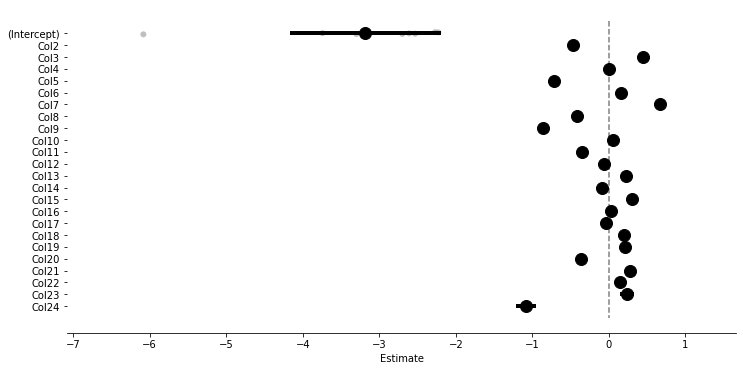

In [ ]:
m.plot_summary()

In [ ]:
m2 = Lmer("Tremor ~ Col2+Col3+Col4+Col5+Col6+Col7+Col8+Col9+Col10+Col11+Col12+Col13+Col14+Col15+Col16+Col17+Col18+Col19+Col20+Col21+Col22+Col23+Col24+(1|ID)", data=data_features_me, family = "binomial")
print(m2.fit())

Formula: Tremor~Col2+Col3+Col4+Col5+Col6+Col7+Col8+Col9+Col10+Col11+Col12+Col13+Col14+Col15+Col16+Col17+Col18+Col19+Col20+Col21+Col22+Col23+Col24+(1|ID)

Family: binomial	 Inference: parametric

Number of observations: 75081	 Groups: {'ID': 8.0}

Log-likelihood: -17795.935 	 AIC: 35641.871

Random effects:

           Name    Var    Std
ID  (Intercept)  1.454  1.206

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE  ...  Prob_97.5_ci  Z-stat  P-val  Sig
(Intercept)    -3.377  -4.212   -2.542  0.426  ...         0.073  -7.925  0.000  ***
Col2           -0.441  -0.476   -0.407  0.018  ...         0.400 -25.131  0.000  ***
Col3            0.367   0.343    0.391  0.012  ...         0.597  29.789  0.000  ***
Col4           -0.056  -0.074   -0.037  0.009  ...         0.491  -5.946  0.000  ***
Col5           -0.731  -0.799   -0.662  0.035  ...         0.340 -20.932  0.000  ***
Col6            0.138   0.074    0.203  0.033  ...         0.55

In [ ]:
m2.plot("(Intercept)")

NameError: ignored